In [13]:
import jax
from typing import Any, Callable, Sequence, Optional
from jax import lax, random, numpy as jnp
jax.config.update("jax_enable_x64", True)
import flax
from flax import linen as nn
import sympy as sy
import numpy as np
import sys
sys.path.append("../")

from eql.eqlearner import EQL
import eql.custom_functions as custom_functions
from eql.symbolic import get_symbolic_expr, get_symbolic_expr_layer
from typing import List, Tuple, Callable
from functools import partial
import matplotlib.pyplot as plt
import cma

In [14]:
import scipy
sys.path.append("../../orient")
from eql.np_utils import flatten, unflatten

In [15]:
#funs = ['sin', 'cos', 'id', 'mul']
funs = ['mul', 'id', 'square']*3
e = EQL(n_layers=2, functions=funs, features=1, use_l0=True, drop_rate=0.8, temperature=2./3)

In [16]:
key = random.PRNGKey(3)
key, k1, k2 = random.split(key, 3)

In [17]:
N = 10000
xdim = 2
x = (random.uniform(key, (N, xdim))-.5) *2 
#x = np.array([[1., 2.]]).T
#x = np.linspace(-1, 1, N)[:,None]
#y = x[:,0] + jnp.cos(x[:,1])
y = x[:,0] * x[:,1]**3


#y = jnp.cos(x) + 1 - x**2 

#y = jnp.cos(x) + 1 - x**2 - jnp.sin(4*x)


def make_l0_func():
    def l0(params, key):
        return e.apply(params, rngs={'l0':key}, method=e.l0_reg)
    return jax.jit(l0)


def my_mse(params, key):
    #pred = e.apply(params, x)
    pred = e.apply(params, x, rngs={'l0': key})
    return jnp.mean((pred-y)**2)


def my_mse(params, key):
    def err(x,y):
        pred = e.apply(params, x, rngs={'l0': key})
        return (pred-y)**2
    return jnp.mean(jax.vmap(err)(x,y))


mse_fn = jax.jit(my_mse)#make_mse_func(x, y)
l0_fn = make_l0_func()

params = e.init({'params':k1, 'l0': k2}, x);

In [18]:
def fex(params, key):
    return jnp.reshape(e.apply(params,  x, rngs={'l0': key}), (1, 1000))

In [19]:
#jax.grad(fex)(params, key)

In [20]:
def loss(params, key):
#     a =  mse_fn(params, key)
#     b = 1e-3*l0_fn(params, key)
#     print(a, b)
#     return a+b
    return mse_fn(params, key) + 1e-2*l0_fn(params, key)
loss_grad_fn = jax.jit(jax.value_and_grad(loss))
loss = jax.jit(loss)

In [21]:
spec, flat = flatten(params)

In [22]:
def np_fn(params, key=None):
    params = unflatten(spec, params)
    if key is None:
        key = jax.random.PRNGKey(42)
    
    key = jax.random.fold_in(key, np_fn.counter)
    loss, grad = loss_grad_fn(params, key)
    _, grad = flatten(grad)
    
    #print(loss)
    np_fn.counter += 1

    return loss, np.array(grad)
np_fn.counter = 0

In [23]:
def np_fn2(params):
    params = unflatten(spec, params)
    np_fn2.key, _ = random.split(np_fn2.key)
    print(mse_fn(params, np_fn2.key), 1e-3*l0_fn(params, np_fn2.key))
    return float(loss(params, np_fn2.key))
np_fn2.key = key

In [24]:
opts = {'maxiter':100, 'verbose': -0}
#opts = {'verbose': -9}

def loss_only(params):
    loss, _ = np_fn(params)
    return float(loss)

res = cma.fmin(loss_only, flat, 1.0, restarts=10, options=opts)
#res = cma.fmin(np_fn2, np.zeros_like(flat), 1.0, restarts=0, options=opts)

(10_w,21)-aCMA-ES (mu_w=6.2,w_1=27%) in dimension 307 (seed=239007, Sun Jan  5 19:02:06 2025)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     21 8.616342868681139e-01 1.0e+00 9.81e-01  1e+00  1e+00 0:01.2
    2     42 8.781333509875799e-01 1.0e+00 9.64e-01  1e+00  1e+00 0:01.3
    3     63 9.593291777520876e-01 1.0e+00 9.48e-01  9e-01  9e-01 0:01.3
   34    714 7.085195869559106e-01 1.0e+00 7.97e-01  8e-01  8e-01 0:04.4
   74   1554 6.249463186817045e-01 1.1e+00 7.66e-01  8e-01  8e-01 0:08.5
  100   2100 6.242089380020317e-01 1.1e+00 7.35e-01  7e-01  7e-01 0:11.0
termination on maxiter=100 (Sun Jan  5 19:02:18 2025)
final/bestever f-value = 6.216103e-01 5.889172e-01 after 2101/2017 evaluations
incumbent solution: [ 0.12803488  0.11381471  0.81756881 -4.26258981  0.26296752  0.71529013
 -0.15066192  0.76988293 ...]
std deviations: [0.73101081 0.73411201 0.73433512 0.73530657 0.73417229 0.73480099
 0.7342707  0.73379596 ...]
(21_w,42)-aCMA-ES (mu_w=11.8,

KeyboardInterrupt: 

In [15]:
symb = get_symbolic_expr(unflatten(spec,res[0]), funs, use_l0=True)
#symb = get_symbolic_expr(unflatten(spec,flat), funs, use_l0=True)

sy.simplify(symb[0])

-0.0846252153799258*x0**4 + 5.55777273830168e-5*x0**3*x1 + 0.104055991830433*x0**3 - 0.000479755274799286*x0**2*x1**2 + 0.0368890534030804*x0**2*x1 - 12.4724046317008*x0**2 + 0.0453372999040783*x0*x1**2 + 3.49477688379538*x0*x1 + 16.4602977673507*x0 - 0.842568816827767*x1**2 - 19.0649007812654*x1 - 62.9791028578645

In [16]:
for i in range(5000):
    key, _ = random.split(key)
    x0, _, info = scipy.optimize.fmin_l_bfgs_b(
            np_fn,
            args=[key],
            x0 = np.array(flat),
            maxfun=4,
            factr=1,
            m=20,
            pgtol=1e-14)
    print(mse_fn(unflatten(spec, flat), key))
    print(l0_fn(unflatten(spec, flat), key))
    flat = x0

0.04888576853758193
77.95147836971769
0.05863749716535199
43.65420823110377
0.05022103347164774
43.64869376684901
0.04920775249689855
43.57028494803514
0.049322035697159004
43.56957111409785
0.06175950221262158
43.54212716412578
0.05163505343058933
43.50425407127348
0.04894110959329354
43.46026760520596
0.049719349573942036
5.077689322531176
0.04888453809739414
5.075353461804696
0.04941630452795722
4.244465580944853
0.048884521831841984
3.4923968282054014
0.049183439177184714
3.1246634540340854
0.0488886805412075
3.124079236741553
0.04888493334597041
2.5513524351267356
0.04888684951297362
2.2892032522779364
0.048884856126590194
2.2887151370915486
0.04888540815584617
1.5536925189066366
0.04888466633669847
1.3946426133639327
0.0488845105532401
1.3944398939864353
0.04906097501149872
0.8708820224111782
0.04888451062258121
0.7370842866823925
0.04896784690663552
0.6000309521116751
0.048884510590661845
0.5346632217809227
0.04893362570530816
0.46144395028748086
0.04888451056493976
0.3233626309

In [17]:
# for i in range(1000):
#     key, k1 = random.split(key)
#     x0, _, info = scipy.optimize.fmin_l_bfgs_b(
#         np_fn,
#         args=[key],
#         x0 = np.array(flat),
#         maxfun=10,
#         factr=1,
#         m=30,
#         pgtol=1e-12)
#     if i % 99 == 0:
#         print(mse_fn(unflatten(spec,x0), key))
#         #print(l0_fn(unflatten(spec,x0), key))
#     flat = x0

In [18]:
#symb = get_symbolic_expr(unflatten(spec, x0), funs)[0]
symb = get_symbolic_expr(unflatten(spec,flat), funs, use_l0=True)
#outs = sy.lambdify("x0", symb[0])(x[:,0])#, x[:,1], x[:,2])
outs = sy.lambdify("x0, x1", symb)(x[:,0], x[:,1])#, x[:,2])

In [19]:
sy.simplify(symb[0])

-0.0255695892985505

ValueError: x and y must be the same size

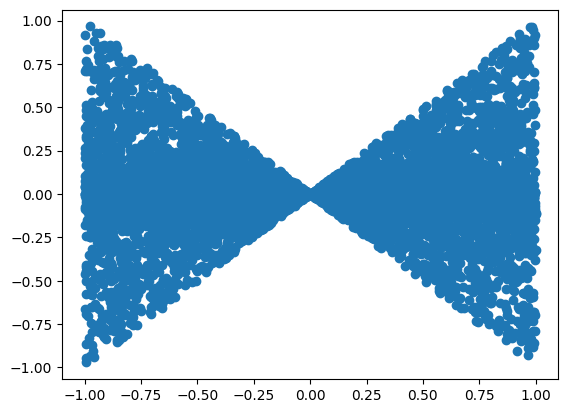

In [20]:
x_flat = np.array(x[:, 0]).flatten()  # Nimm die erste Spalte und mache sie 1D
y_flat = np.array(y).flatten() 
plt.scatter(x_flat,y_flat)
#plt.scatter(x,e.apply(unflatten(spec, x0), x),alpha=.3,marker='.')

if isinstance(outs, list) and len(outs) == 1:
    outs = np.array(outs[0]).flatten()  # Extrahiere das innere Array
else:
    outs = np.array(outs).flatten()


plt.scatter(x_flat,outs)

In [ ]:
def loss(params, key):
#     a =  mse_fn(params, key)
#     b = 1e-3*l0_fn(params, key)
#     print(a, b)
#     return a+b
    return mse_fn(params, key) + 5e-3*l0_fn(params, key)
loss_grad_fn = jax.jit(jax.value_and_grad(loss))
loss = jax.jit(loss)

NameError: name 'jax' is not defined

In [ ]:
import optax
tx = optax.adam(learning_rate=1e-3)
opt_state = tx.init(params)
loss_grad_fn = jax.jit(jax.value_and_grad(loss))

In [ ]:
for i in range(10_000):
    key, k1 = random.split(key)
    loss_val, grads = loss_grad_fn(params, key)
    updates, opt_state = tx.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    if i % 99 == 0:
        print(loss_val)
        print(mse_fn(params, key))
        print(l0_fn(params, key))

0.43866878175539614
0.04890186739485571
77.91662157650438
0.42129053960785784
0.048814966580620234
74.45856964975741
0.40404129142095924
0.04887955572610834
70.99747901630087
0.3867104102642046
0.048824312132812235
67.54247823355401
0.3695715099347391
0.04880628863712643
64.11873774201959
0.35273804651351304
0.0488642654770086
60.74095427291291
0.3362066021726738
0.04888487626117485
57.43132155653011
0.3201459432591182
0.04888462082700818
54.22035321925371
0.304625118374665
0.048880965108615226
51.11811996239072
0.28975147664836665
0.04888527037349799
48.14385058368185
0.27554218130073355
0.048884528347562836
45.30352970819228
0.2620355564521446
0.048884692323663374
42.603617118008486
0.24933244875684532
0.048966520787358934
40.04676306146528
0.2371691540033028
0.04888453210701685
37.633276181182126
0.22633832331938605
0.04941468490489925
35.361913895043514
0.21470103187660805
0.04844608189328343
33.228850736410834
0.2051347429420976
0.04888732764937513
31.229908695844863
0.19577264237

In [ ]:
symb = get_symbolic_expr(params, funs, use_l0=True)[0]


NameError: name 'get_symbolic_expr' is not defined

In [ ]:
symb

0.00557709655175115

In [ ]:
sy.expand(symb)

0.00557709655175115

In [ ]:
jit_apply = jax.jit(e.apply, static_argnames='deterministic')

In [ ]:
jit_part = partial(jit_apply, params)
#jax.grad(jit_part)(x)

In [ ]:
e.apply(params, rngs={'l0': k1}, method=e.l0_reg)

Array(0.55123361, dtype=float64)

In [ ]:
k1, _ = random.split(k1)
e.apply(params, x, deterministic=False, rngs={'l0': k1})

Array([[0.00406649],
       [0.00406649],
       [0.00406649],
       ...,
       [0.00406649],
       [0.00406649],
       [0.00406649]], dtype=float64)

In [ ]:
k1, _ = random.split(k1)
jit_apply(params, x, deterministic=False, rngs={'l0': k1})

Array([[0.00406649],
       [0.00406649],
       [0.00406649],
       ...,
       [0.00406649],
       [0.00406649],
       [0.00406649]], dtype=float64)

In [ ]:
symb = get_symbolic_expr(unflatten(spec, x0), funs)
sy.lambdify("x0, x1, x2", symb[0])(x[:,0], x[:,1], x[:,2])

Array([-0.65474885, -0.00339308, -0.01673615, ..., -0.82825534,
       -1.30095766, -1.04139071], dtype=float64)

In [ ]:
sy.lambdify(sy.symbols("x0, x1"), symb[1], "numpy")(x[:,0],x[:,1])

DeviceArray([ 0.29320884, 20.998196  ,  3.2638202 ], dtype=float32)